![](WAZE.png)
# Waze User Churn Project: Results of EDA
Waze is a free navigation app that makes it easier for drivers around the world to get to where they want to go. Waze leadership wants to optimize the company’s retention strategy, enhance user experience, and make data-driven decisions about product development. They would like an analysis of WAZE data to understand their users better and the development of a machine learning model that predicts user churn. (Churn is understood to be the number of users who have uninstalled the Waze app or stopped using it.) 

This project is part of a larger effort at Waze to increase growth. It assumes that high retention rates indicate satisfied users who repeatedly employ the Waze app over time. Identifying and predicting which users are likely to churn will allow the WAZE team to target such individuals to induce their retention, thereby allowing Waze to grow its business. 

**Data**    
Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users help make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely. The data set is in-house from Waze for Cities (https://www.transportation.gov/office-policy/transportation-policy/faq-waze-data).

**Deliverables**   
(Since this is an exercise, all models are predetermined.)
* I.	An analysis of WAZE data to understand their users better
* II.	The development of a machine learning model that predicts user churn
    * a.	a binomial logistic regression model
    * b.	a winning tree-based model
* Appendix: A 2 sample t-test based on a sample of user data determining if there is a statistically significant difference in the mean number of rides between iPhone® users and Android™ users

# PART III: Build and test two tree-based models: random forest and XGBoost
* basic EDA
* prepare data for modelling
* build models

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import preprocessing, modeling, and evaluation packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Import from xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

# Import visualization package
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# Save models once fitted.
import pickle

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

In [2]:
# Import data; create df
df0 = pd.read_csv('WAZE_dataset_transformed_2.csv', on_bad_lines='skip')
df0.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,percent_sessions_in_month,total_sessions_per_day,kms_driven_per_day_during_the_month,km_per_drive,km_per_hour,professional_driver,label2,device2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,0.936313,0.130381,138.360267,11.632058,79.430298,1,0,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,0.406856,0.266854,1246.901868,128.186173,260.389902,1,0,1
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,0.841186,0.051121,382.393602,32.201567,113.953460,0,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,0.724968,1.089743,304.530374,22.839778,93.351141,0,0,1
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,0.499266,0.107713,219.455667,58.091206,194.342970,0,0,0


### BASIC EDA revisted
* check for nulls
* check dtypes: decision trees need numeric columns, so any must be converted to ordinals
* no need to be concerned with outliers, since DTs can handle them
* encode variables

In [3]:
# Call info on new df
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   label                                14299 non-null  object 
 1   sessions                             14299 non-null  int64  
 2   drives                               14299 non-null  int64  
 3   total_sessions                       14299 non-null  float64
 4   n_days_after_onboarding              14299 non-null  int64  
 5   total_navigations_fav1               14299 non-null  int64  
 6   total_navigations_fav2               14299 non-null  int64  
 7   driven_km_drives                     14299 non-null  float64
 8   duration_minutes_drives              14299 non-null  float64
 9   activity_days                        14299 non-null  int64  
 10  driving_days                         14299 non-null  int64  
 11  device                      

In [4]:
df0.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,percent_sessions_in_month,total_sessions_per_day,kms_driven_per_day_during_the_month,km_per_drive,km_per_hour,professional_driver,label2,device2
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,0.448226,0.203300,484.488544,168.147169,165.698737,0.228338,0.177355,0.645150
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,0.283954,0.267737,570.872328,232.903899,110.185653,0.419776,0.381982,0.478485
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000298,0.000000,0.000000,72.013095,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,0.196890,0.050818,136.168003,32.486524,90.649402,0.000000,0.000000,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,0.424310,0.100457,273.301012,72.947059,122.105845,0.000000,0.000000,1.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,0.687251,0.215210,558.018761,179.347527,193.238449,0.000000,0.000000,1.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,0.936313,1.089743,2258.494484,913.878779,488.824224,1.000000,1.000000,1.000000


In [5]:
# Check for missing values
print(df0.isnull().sum())
df0.shape

label                                  0
sessions                               0
drives                                 0
total_sessions                         0
n_days_after_onboarding                0
total_navigations_fav1                 0
total_navigations_fav2                 0
driven_km_drives                       0
duration_minutes_drives                0
activity_days                          0
driving_days                           0
device                                 0
percent_sessions_in_month              0
total_sessions_per_day                 0
kms_driven_per_day_during_the_month    0
km_per_drive                           0
km_per_hour                            0
professional_driver                    0
label2                                 0
device2                                0
dtype: int64


(14299, 20)

#### Encode variables and feature selection
* drop device and label (these have been previously encoded as device2 and label2)
* no need to drop others (tree-based models can handle multicollinearity)

In [6]:
# Drop `device and label` columns since they don't contain any information relevant to churn
df = df0.drop(['device', 'label'], axis=1)
df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,percent_sessions_in_month,total_sessions_per_day,kms_driven_per_day_during_the_month,km_per_drive,km_per_hour,professional_driver,label2,device2
0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,0.936313,0.130381,138.360267,11.632058,79.430298,1,0,0
1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,0.406856,0.266854,1246.901868,128.186173,260.389902,1,0,1
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,0.841186,0.051121,382.393602,32.201567,113.953460,0,0,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,0.724968,1.089743,304.530374,22.839778,93.351141,0,0,1
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,0.499266,0.107713,219.455667,58.091206,194.342970,0,0,0


## Prepare data for modelling
* choose evaluation metric: recall, since the logistic regression model had a terrible recall
* no need to check for multicollinearity - DTs can handle them

Split the data into:
* features and target variable
* training data(80%) and test data(20%)
* split separate validation data. Set 75/25 into a training set and a validation set to get 75% of 80%
* stratify= y to ensures that splitting maintains same proportion of different classes or groups that are present in the target variable y 
* set a random seed so work can be reproduced (42)

In [7]:
# Check class balance for target variable label2
print(df0['label2'].value_counts())
print(df0['label2'].value_counts(normalize=True))

label2
0    11763
1     2536
Name: count, dtype: int64
label2
0    0.822645
1    0.177355
Name: proportion, dtype: float64


Class rebalancing   
~ 18% of the users in this dataset churned and ~82% retained. This is a slightly unbalanced dataset, but the DTs can handle it and so it can be modeled without any class rebalancing.    

Metrics  
*Accuracy* can be misleading if the data set is unbalanced. The algorithm could be poor at balancing false positive and false negatives because it does not account as well for the distribution of classes (churned/retained) as in the case of the logistic regression model. The model could be excellent at predicting one class (e.g., the majority[retained]) and terrible at predicting the other (e.g., the minority[churned]) and return a very good accuracy score. 

*Precision* In its goal to be precise (not classify people as churned when they are retained, the algorithm can become more selective. A higher rate of precision may mean that more samples are classified as retained, when they churn (false-negative/Type II errors). Thus, users set to churn can be missed.   

*F1* balances both recall and precision, but here concentrating on recall would be more productive

*Recall* is the chosen eveluation metric

In [8]:
# Subset data into dependent y(target) and independent X variables
X = df.drop(columns=['label2'])
y = df['label2']

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

In [9]:
# Verify number of samples in the partitioned data
print("X")
print(X.info())
print("y")
print(y.info())

X
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   sessions                             14299 non-null  int64  
 1   drives                               14299 non-null  int64  
 2   total_sessions                       14299 non-null  float64
 3   n_days_after_onboarding              14299 non-null  int64  
 4   total_navigations_fav1               14299 non-null  int64  
 5   total_navigations_fav2               14299 non-null  int64  
 6   driven_km_drives                     14299 non-null  float64
 7   duration_minutes_drives              14299 non-null  float64
 8   activity_days                        14299 non-null  int64  
 9   driving_days                         14299 non-null  int64  
 10  percent_sessions_in_month            14299 non-null  float64
 11  total_sessions_per_day    

In [10]:
# Get balances of each training, validation, and testing sets
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8579, 17), (2860, 17), (2860, 17), (8579,), (2860,), (2860,))

This aligns with expectations.

### Build random forest model
* instantiate RF model
* define and tune hyperparameters
* define scoring criteria: use recall as metric
* construct GridSearch cross-validation
* fit model to training data

In [11]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [None, 2, 5, 6],
             'max_features': [0.7, 2, 4],
             'max_samples': [0.5, 0.7, 1],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [0.001, 0.01, 2, 4, 5], # small fractional values allows can help capture patterns in minority classes 
                                                        # fixed values (like 4) can prevent the creation of very small nodes that could lead to overfitting on the majority class.
             'n_estimators': [50, 100, 125], # how deep the tree is allowed to grow
             }

In [12]:
from sklearn.metrics import precision_score, make_scorer

# Define scoring criteria
precision_scorer = make_scorer(precision_score, zero_division=0)
                             # Instructs scikit-learn to assign a precision of 0 when no predicted positives, to migate continued percision warnings when fitting model
scoring = {'accuracy': 'accuracy', 'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

In [13]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
RF_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [14]:
# Fit model to the training data & call magic function time to time execution
%time
RF_cv.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 2, 5, 6],
                         'max_features': [0.7, 2, 4],
                         'max_samples': [0.5, 0.7, 1],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [0.001, 0.01, 2, 4, 5],
                         'n_estimators': [50, 100, 125]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': 'recall'})

In [15]:
# Examine best average score across all the validation folds
RF_cv.best_score_

0.12876260533222822

In [16]:
# Examine best combination of hyperparameters
RF_cv.best_params_

{'max_depth': None,
 'max_features': 0.7,
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [17]:
# Create a metrics results table with make_results function which returns a df with metrics for the RF model with the best mean 'metric' score across all validation folds
# In this case: the best mean recall score

def make_results(model_name:str, model_object, metric:str):  # model_name: name, model_object: a fit GridSearchCV object, metric:str
    
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }
    
    cv_results = pd.DataFrame(model_object.cv_results_) # Create df for all results
    
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :] # idxmax() returns a series with the index of the max value for each col
    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                         },)
    return table

In [18]:
# Pass the GridSearch object to the make_results() function.
RF_cv_results = make_results('Random Forest cv', RF_cv, 'recall')
RF_cv_results

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.454665,0.128763,0.81816,0.200545


In [19]:
# Read in master results table
models_table = pd.read_csv('Retention_Results.csv')
models_table

,Model,Precision,Recall,Accuracy,F1
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102


In [20]:
# Concatentate decision tree model results table with master results table
models_table = pd.concat([models_table, RF_cv_results])
models_table

,Model,Precision,Recall,Accuracy,F1
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102
0,Random Forest cv,0.454665,0.128763,0.818160,0.200545


In [21]:
# Save the master results table
models_table.to_csv('Retention_Results.csv', index=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102
0,Random Forest cv,0.454665,0.128763,0.818160,0.200545


#### Pickle the model (save)

In [22]:
# Pickle the model
with open('RF_cv_WAZE.pickle', 'wb') as to_write: # wb = write binary
    pickle.dump(RF_cv, to_write)

In [23]:
# Read in pickled model
with open('RF_cv_WAZE.pickle', 'rb') as to_read: # rb = read binary
    RF_cv = pickle.load(to_read)

## Build an XGBoost model
* instantiate XGBoost model
* define and tune hyperparameters
* define scoring criteria: use recall as metric
* construct GridSearch cross-validation
* fit model to training data

In [24]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [2, 6, 12],
             'min_child_weight': [0.5, 3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [150, 200, 300]
             }

from sklearn.metrics import precision_score, make_scorer

# Define scoring criteria
precision_scorer = make_scorer(precision_score, zero_division=0)
                             # Instructs scikit-learn to assign a precision of 0 when no predicted positives, to migate continued percision warnings when fitting model
scoring = {'accuracy': 'accuracy', 'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

In [25]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
XGB_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [26]:
# Fit the model to the X_train and y_train data 
%time
XGB_cv.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 6, 12],
                         'min_child_weight': [0.5, 3, 5],
                         'n_estimators': [150, 200, 300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': 'recall'})

In [27]:
# Examine best score
XGB_cv.best_score_

0.1714843210388175

In [28]:
# Examine best parameters
XGB_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [29]:
# Pass the GridSearch object to the make_results() function.
XGB_cv_results = make_results('XGBoost cv', XGB_cv, 'recall')
XGB_cv_results

,Model,Precision,Recall,Accuracy,F1
0,XGBoost cv,0.404893,0.171484,0.808135,0.24083


In [30]:
# Concatentate decision tree model results table with master results table
models_table = pd.concat([models_table, XGB_cv_results])
models_table

,Model,Precision,Recall,Accuracy,F1
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102
0,Random Forest cv,0.454665,0.128763,0.818160,0.200545
0,XGBoost cv,0.404893,0.171484,0.808135,0.240830


In [31]:
# Save the master results table
models_table.to_csv('Retention_Results.csv', index=False);

In [32]:
# View the results
models_table = pd.read_csv('Retention_Results.csv')
models_table = models_table.sort_values(by=['Recall'], ascending=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
2,XGBoost cv,0.404893,0.171484,0.808135,0.240830
1,Random Forest cv,0.454665,0.128763,0.818160,0.200545
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102


#### Pickle the model (save)

In [33]:
# Pickle the model
with open('XGB_cv_WAZE.pickle', 'wb') as to_write: # wb = write binary
    pickle.dump(XGB_cv, to_write)

In [34]:
# Read in pickled model
with open('XGB_cv_WAZE.pickle', 'rb') as to_read: # rb = read binary
    XGB_cv = pickle.load(to_read)

### Use models with validation set
* Random forest model
* XGBoost model

#### Random forest model on validation set

In [35]:
# Use random forest model to predict on validation data with best tree
RF_val_preds = RF_cv.best_estimator_.predict(X_val)

In [36]:
# Use get_test_scores funtion to create a table with test scores
def get_test_scores(model_name:str, preds, y_test_data):   # model_name: name, preds: predictions, y_test_data: y_test data

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    
# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                          },)

    return table

In [37]:
# Pass the scores get_test_scores function
RF_cv_val = get_test_scores('Random Forest Val', RF_val_preds, y_val)
RF_cv_val

,Model,Precision,Recall,Accuracy,F1
0,Random Forest Val,0.423077,0.108481,0.815734,0.172684


In [38]:
# Concatentate decision tree model results table with master results table
models_table = pd.concat([models_table, RF_cv_val])
models_table

,Model,Precision,Recall,Accuracy,F1
2,XGBoost cv,0.404893,0.171484,0.808135,0.240830
1,Random Forest cv,0.454665,0.128763,0.818160,0.200545
0,Logistic Regression,0.535088,0.096215,0.824895,0.163102
0,Random Forest Val,0.423077,0.108481,0.815734,0.172684


In [39]:
# Save the master results table
models_table.to_csv('Retention_Results.csv', index=False);

In [40]:
# View the results
models_table = pd.read_csv('Retention_Results.csv')
models_table = models_table.sort_values(by=['Recall'], ascending=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
0,XGBoost cv,0.404893,0.171484,0.808135,0.240830
1,Random Forest cv,0.454665,0.128763,0.818160,0.200545
3,Random Forest Val,0.423077,0.108481,0.815734,0.172684
2,Logistic Regression,0.535088,0.096215,0.824895,0.163102


#### XGBoost model on validation set

In [41]:
# Use XGBoost model to predict on validation data with best tree
XGB_val_preds = XGB_cv.best_estimator_.predict(X_val)

In [42]:
# Pass the scores get_test_scores function 
XGB_val = get_test_scores('XGBoost Val', XGB_val_preds, y_val)
XGB_val

,Model,Precision,Recall,Accuracy,F1
0,XGBoost Val,0.412037,0.175542,0.809441,0.246196


In [43]:
# Concatentate decision tree model results table with master results table
models_table = pd.concat([models_table, XGB_val])

In [44]:
# Save the master results table
models_table.to_csv('Retention_Results.csv', index=False);

In [45]:
# View the results
models_table = pd.read_csv('Retention_Results.csv')
models_table = models_table.sort_values(by=['Recall'], ascending=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
4,XGBoost Val,0.412037,0.175542,0.809441,0.246196
0,XGBoost cv,0.404893,0.171484,0.808135,0.240830
1,Random Forest cv,0.454665,0.128763,0.818160,0.200545
2,Random Forest Val,0.423077,0.108481,0.815734,0.172684
3,Logistic Regression,0.535088,0.096215,0.824895,0.163102


## Use best model on test data
The above table shows, when refitted to Recall, the XGB Boost model performed better than the random forest model on both the training and validation sets. It also performed better than the logistic regression model.  It will be used with the test data.

In [46]:
# Use XGBoost model to predict on test data with best tree
XGB_test_preds = XGB_cv.best_estimator_.predict(X_test)

In [47]:
# Pass the scores get_test_scores function.
XGB_test = get_test_scores('XGBoost TEST', XGB_test_preds, y_test)
XGB_test

,Model,Precision,Recall,Accuracy,F1
0,XGBoost TEST,0.4,0.17357,0.807343,0.242091


In [48]:
# Concatentate decision tree model results table with master results table
models_table = pd.concat([models_table, XGB_test])

In [49]:
# Save the master results table
models_table.to_csv('Retention_Results.csv', index=False);

In [50]:
# View the results
models_table = pd.read_csv('Retention_Results.csv')
models_table = models_table.sort_values(by=['Recall'], ascending=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
0,XGBoost Val,0.412037,0.175542,0.809441,0.246196
5,XGBoost TEST,0.400000,0.173570,0.807343,0.242091
1,XGBoost cv,0.404893,0.171484,0.808135,0.240830
2,Random Forest cv,0.454665,0.128763,0.818160,0.200545
3,Random Forest Val,0.423077,0.108481,0.815734,0.172684


#### Results
All metrics for the XGBoost model fitted to the unseen test data decreased slightly, but this is to be expected. Recall score dropped ever so slightly to 0.1735 from 0.1755, Precision also decreased from 0.4120 to 0.4000 and Accuracy went from 0.8094 to 0.8073. Finally, F1 changed from 0.2461 to 0.2420.

The XGBoost model also performed less well than the random forest in Precision and Accuracy; however, the goal was to boost the Recall score, where it performed several points higher. The combined F1 score demonstrates this.

In [52]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, XGB_test_preds, target_names = target_labels))

              precision    recall  f1-score   support

    retained       0.84      0.94      0.89      2353
     churned       0.40      0.17      0.24       507

    accuracy                           0.81      2860
   macro avg       0.62      0.56      0.57      2860
weighted avg       0.76      0.81      0.77      2860



### Visualizations and evaluations on test model
* plot a confusion matrix
* get best features
* plot ROC curve
* commute AUC

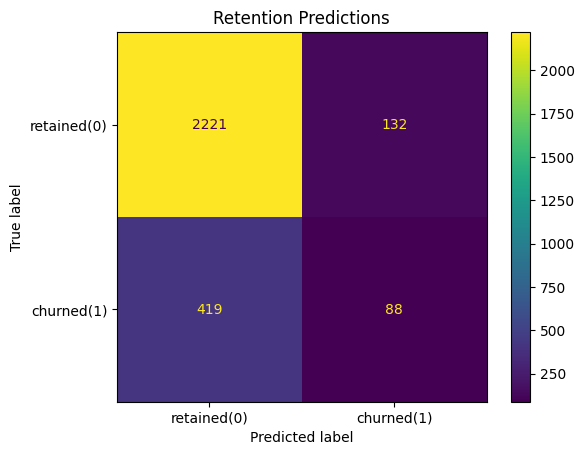

In [53]:
cm = confusion_matrix(y_test, XGB_test_preds, labels=XGB_cv.classes_)

# Plot confusion matrix
XGB_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained(0)', 'churned(1)'])
XGB_disp.plot()
plt.title('Retention Predictions');

*Legend*
* 0 = the person was labeled as retained for that observation
* 1 = a person was labeled as churned for that observation

*Translation*<br>
`True negatives`(UL): # of people that were retained(0) that the model accurately predicted as retained(0) = 2221   
`True positives`(LR): # of people that churned(1) that the model accurately predicted churned(1) = 88   
`False positives`(UR)/ Type I Errors: # of people that were retained(0) that the model inaccurately predicted churned(1) = 132   
`False negatives`(LL)/Type II Errors: # of people that churned(1) that the model inaccurately predicted were retained(0) = 419   

The XGBoost model both predicted more users who would churn and missed more users who would churn (Type I Errors) than the logistic regression model. It also correctly predicted fewer users who would stay, while at the same time had fewer false identifications of those who would leave.

#### Plot ROC and AOC

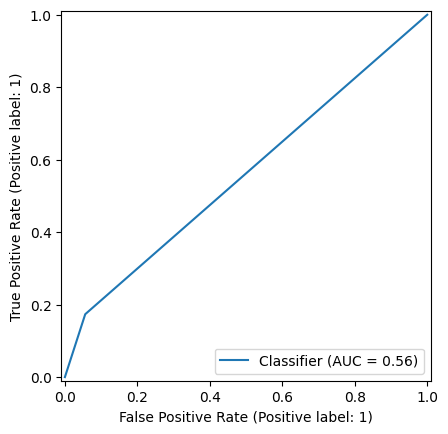

In [54]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, XGB_test_preds)
plt.show()

In [55]:
# Compute the AUC
roc_auc_score(y_test, XGB_test_preds)

0.5587357110944021

Results    
The champion XGBoost model performed slightly better (0.54 > 0.56) across all possible classification thresholds (classification decisions) than the logistic regression model. 

With an AUC score of ~56%, it performs ~6% better than random classification (50%).

#### Plot feature importance

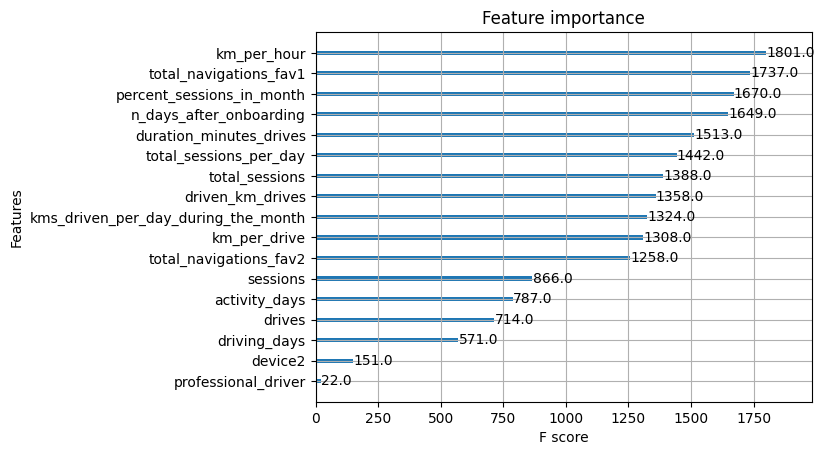

In [56]:
plot_importance(XGB_cv.best_estimator_);

#### Results    
According to the feature importance plot, the rate at which a driver drove (`km_per_hour`) and whether or not they took advantage of the favorite navigations feature (`total_navigations_fav1`) were the most predictive features in the data set. Second were `percent_sessions_in_month` and `n_days_after_onboarding`. The created feature `professional_driver` had little to no impact on predictability. Also, the device a user used (`device2`) was not relevant for the model's calculations.

However, relying on the results of a feature importance rank in an unbalanced data such as this one is not wise, since it can be biased towards the majority class. This is especially true when it is the minority class that is the target. Feature importance may prioritize features that are more prevalent in the majority class, thereby missing those features crucial for predicting the minority class.

#### Plot precision-recall curve

In [57]:
from sklearn.metrics import PrecisionRecallDisplay

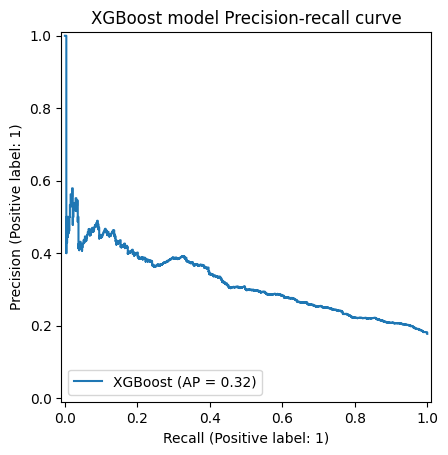

In [58]:
# Compute precision-recall pairs for different probability thresholds
display = PrecisionRecallDisplay.from_estimator(XGB_cv.best_estimator_, X_test, y_test, name='XGBoost')
plt.title('XGBoost model Precision-recall curve');

Results    
Precision is a metric that quantifies the number of correct positive predictions made. \
Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

As recall increases, precision decreases. 

The precision-recall curve plots precision (y-axis) and recall (x-axis) for different probability thresholds. In a balanced dataset this is at 50% by default. The "high" rating of the ROC curve reflects the majority class. Here, the curve is more "honest," with a 32% score.

Since a false positive is less of a concern for this data set because the goal is to predicate users who churn (the minority) accidently reaching out to a user would wouldn't even without contact would likely not have major negative consequences = low risk. The 50% threshold should be lowered.

**Create new threshold**
* the 1st # in the row is the probability of belonging to the negative class
* the 2nd # in the row is the probability of belonging to the positive class
* together they will = 1

Changing the threshold of a positive response where any users who have a value ≥ 0.4 (as opposed to ≥ 0.5) in the 2nd column will get assigned a prediction of `1` = they churned.

In [59]:
# Get predicted probabilities on the test data to return a 2-D array of probabilities where each row represents a user
predicted_probabilities = XGB_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.97620225, 0.02379777],
       [0.7518184 , 0.24818155],
       [0.9936058 , 0.00639419],
       ...,
       [0.8098501 , 0.19014993],
       [0.9927123 , 0.00728769],
       [0.7999854 , 0.20001458]], dtype=float32)

In [60]:
# Create a probs list for the 2nd column
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
# Get evaluation metrics for new threshold
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,Model,Precision,Recall,Accuracy,F1
0,"XGB, threshold = 0.4",0.36858,0.240631,0.792308,0.291169


In [62]:
# View results table
models_table = pd.read_csv('Retention_Results.csv')
models_table = models_table.sort_values(by=['Recall'], ascending=False)
models_table.head()

,Model,Precision,Recall,Accuracy,F1
0,XGBoost Val,0.412037,0.175542,0.809441,0.246196
5,XGBoost TEST,0.400000,0.173570,0.807343,0.242091
1,XGBoost cv,0.404893,0.171484,0.808135,0.240830
2,Random Forest cv,0.454665,0.128763,0.818160,0.200545
3,Random Forest Val,0.423077,0.108481,0.815734,0.172684


Result \
Recall went up significantly as did the combined F1 score. In spite of the fact that Precision went down, Accuracy still held at ~80%.

In [63]:
# Create function to arrive at perfect threshold for desired Recall score
def threshold_finder(y_test_data, probabilities, desired_recall): # y_test_data: Array of true y values, probabilities:  results of `predict_proba()`

    probs = [x[1] for x in probabilities]  # Isolate 2nd column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        preds = np.array([1 if x >= threshold else 0 for x in probs]) # new array of {0, 1} predictions based on new threshold
         
        recall = recall_score(y_test_data, preds) # Calculate recall score for that threshold
       
    # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))
        distances = []
        for idx, score in enumerate(scores):
            distance = abs(score[1] - desired_recall) # Calculates how close each actual score is to the desired score
            distances.append((idx, distance)) # Appends the (index#, distance) tuple to `distances`

    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False) # Sorts `distances` by 2nd value in each of its tuples (< to >)
   
    best = sorted_distances[0] # Identify the tuple with actual recall closest to desired recall
    
    best_idx = best[0] # Isolate index of threshold with closest recall score
    
    threshold, recall = scores[best_idx]  # Retrieve threshold and actual recall score closest to desired recall

    return threshold, recall

In [64]:
# Get the predicted probabilities best XGBoost model
probabilities = XGB_cv.best_estimator_.predict_proba(X_test)

# Call threshold_finder function
threshold_finder(y_test, probabilities, 0.5)

(0.134, 0.5009861932938856)

Setting a threshold of 0.134 will result in a recall of 0.50.

In [65]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.134 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.134', new_preds, y_test)

,Model,Precision,Recall,Accuracy,F1
0,"XGB, threshold = 0.134",0.297773,0.500986,0.702098,0.373529


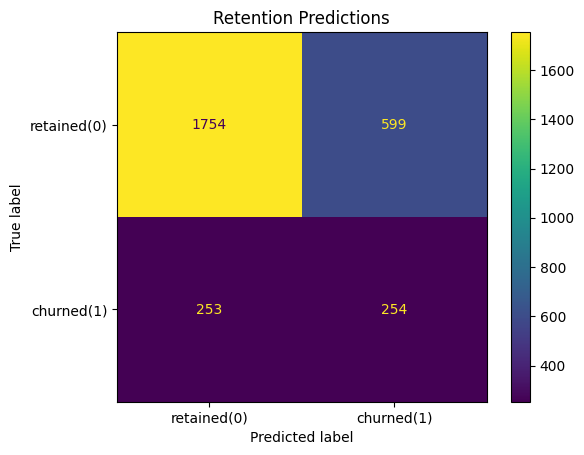

In [66]:
cm = confusion_matrix(y_test, new_preds, labels=XGB_cv.classes_)

# Plot confusion matrix
XGB_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained(0)', 'churned(1)'])
XGB_disp.plot()
plt.title('Retention Predictions');

#### Results    
*Metrics* \
With the new threshold, Precision drops precipitously, however, depending on the cost expended to reach ot to users who might churn this could be an acceptable outcome. Accuracy is still relatively high at 70%.

*Confusion matrix* \
True negatives(UL): # of people that were retained(0) that the model accurately predicted as retained(0) = 1774 (< 2221)\
True positives(LR): # of people that churned(1) that the model accurately predicted churned(1) = 254 (> 88)\
False positives(UR)/ Type I Errors: # of people that were retained(0) that the model inaccurately predicted churned(1) = 599 (> 132)\
False negatives(LL)/Type II Errors: # of people that churned(1) that the model inaccurately predicted were retained(0) = 253 (< 419)

With the new threshold, 166 more churned users were identified, although the number of incorrectly users predicted to churn rose significantly (Type I Error); however, the number of Type II Errors decreased from 419 to 253, meaning that with the lower threshold, the model predicts significantly better.


## Results of the winning XGBoost model on the test data set 
Out of the 2,860 users in the test data set, 507 churned. Of these, the XGBoost model captured 88, thereby achieving an ~18% Recall. The test data set also included 2353 remaining users. Of these, the model captured 2221 – missing only 132. By refitting the model to Recall, this also drove the F1 up from the logistic regression model to ~25%. This metric balances the scores the model received in predicting either churned or retained users.
 
Since the goal of this project is to build a model which can predict whether a user will churn using the available variables, this model’s performance is less than stellar. However, these results are somewhat expected in a data set as unbalanced as this one is. 

*Boosting results further* \
In order to account for the imbalance in the dataset, the threshold at which the model classified a user as likely to churn was adjusted. Targeting a 50% Recall required the threshold be set to 0.134 and this provided far more satisfactory results. With this new threshold setting, out of the 507 churned users in the test data the model now captured 254 (166 more users) and the number of Type II errors decreased from 419 to 253, meaning that with the lower threshold the model predicts significantly better. This altered threshold did mean that the number of users incorrectly predicted to churn rose significantly (Type I error), lowering Precision from ~41% to ~30%. In an effort to identify more customers, the model will become more sensitive to finding churned users and will become prone to incorrectly categorizing people as churned (false-positives/Type-I error) when they remained. This then lowers the Precision score.

Finally, although Accuracy also decreased to 70% (from ~80%), F1 increased substantially from ~25% to ~37%. This means that on the whole the model was far better at achieving the desired result: locating users who would churn.

*Most predictive features* \
According to the feature importance plot, the rate at which a driver drove (`km_per_hour`) and whether or not they took advantage of the favorite navigations feature (`total_navigations_fav1`) were the most predictive features in the data set. Second were `percent_sessions_in_month` and `n_days_after_onboarding`. The created feature `professional_driver` had little to no impact on predictability. Also, the device a user used (`device2`) was not relevant for the model's calculations.
 
However, relying on the results of a feature importance rank in an unbalanced data set such as this one is not wise, since it can be biased towards the majority class. This is especially true when it is the minority class that is the target. Feature importance may prioritize features that are more prevalent in the majority class, thereby missing those features crucial for predicting the minority class.


### Going Forward

As is, this XGBoost model with the revised threshold could be used to predict users who churn, if the company’s retention strategy is cost productive per user. This is because the model will make more Type-I errors. It will classify users as likely to churn when they would not, regardless of intervention. 

* Alternatively, the data could be scaled so that the minority class (churned users) is more rep-resented or majority class deemphasized.
* Or, new models could be built using more or different features. For example, the data set does not contain true records of total drives.
* Finally, it might be helpful to learn why so many sessions seem to have taken place in the last month.